In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import warnings
warnings.filterwarnings('ignore')

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Импортируем датасет
# Загрузка данных
try:
    # Пробуем загрузить из локального файла
    train_df = pd.read_csv('train.csv')
    test_df = pd.read_csv('test.csv')
    print("Данные загружены из локальных файлов")
except:
    # Если файлов нет, загружаем с Kaggle (требуется наличие kaggle.json)
    try:
        !kaggle competitions download -c titanic
        import zipfile
        with zipfile.ZipFile('titanic.zip', 'r') as zip_ref:
            zip_ref.extractall('.')
        train_df = pd.read_csv('train.csv')
        test_df = pd.read_csv('test.csv')
        print("Данные загружены с Kaggle")
    except:
        # Альтернативный способ - загрузка из интернета
        import io
        import requests

        train_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
        train_df = pd.read_csv(train_url)
        test_df = None
        print("Данные загружены из интернета (только train)")

print(f"Размер обучающего датасета: {train_df.shape}")
print(f"Размер тестового датасета: {test_df.shape if test_df is not None else 'Не загружен'}")

Could not find kaggle.json. Make sure it's located in C:\Users\buriy\.kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
Данные загружены из интернета (только train)
Размер обучающего датасета: (891, 12)
Размер тестового датасета: Не загружен


Разведочный анализ
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500 

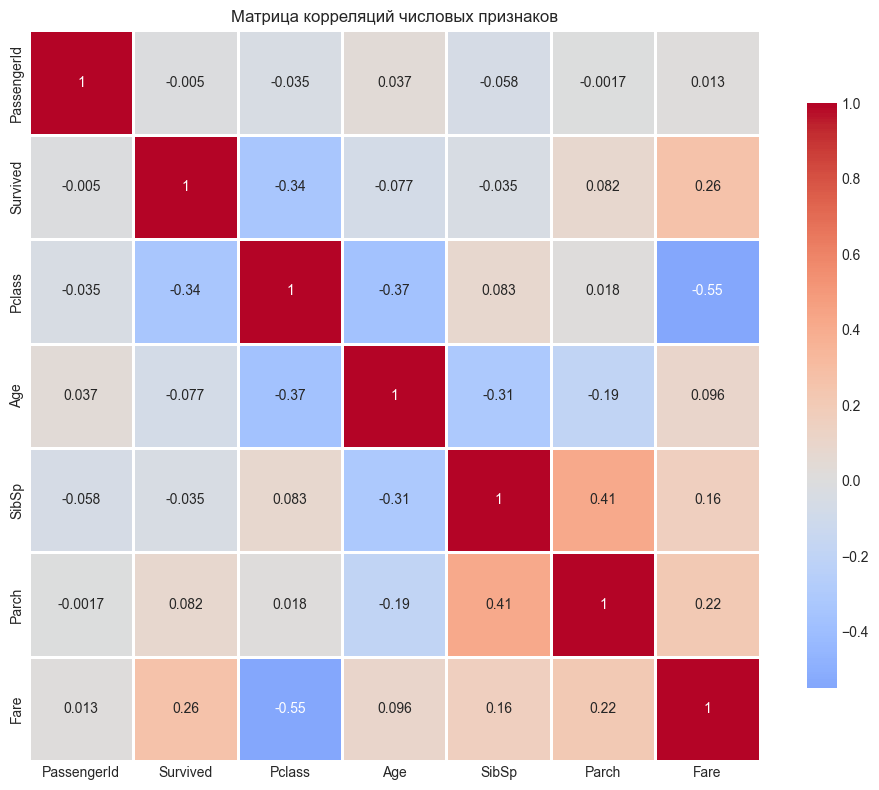


Корреляция с целевой переменной Survived:
Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


In [3]:
# Производим разведочный анализ данных
print("Разведочный анализ")

# 1. Первый взгляд на данные
print(train_df.head())

print(train_df.info())

print(train_df.describe())

print(train_df.describe(include=['O']))

# 2. Проверка пропущенных значений
missing_values = train_df.isnull().sum()
missing_percent = (missing_values / len(train_df)) * 100
missing_df = pd.DataFrame({
    'Пропущенных значений': missing_values,
    'Процент пропусков': missing_percent.round(2)
})
print(missing_df[missing_df['Пропущенных значений'] > 0])

# Анализ целевой переменной (Survived)
print("Анализ целевой переменной (Survived):")
survival_counts = train_df['Survived'].value_counts()
survival_percent = train_df['Survived'].value_counts(normalize=True) * 100

print(f"Выжило: {survival_counts[1]} ({survival_percent[1]:.1f}%)")
print(f"Не выжило: {survival_counts[0]} ({survival_percent[0]:.1f}%)")

# Пол
sex_survival = pd.crosstab(train_df['Sex'], train_df['Survived'])
sex_survival_percent = sex_survival.div(sex_survival.sum(1), axis=0) * 100

# Класс
class_survival = pd.crosstab(train_df['Pclass'], train_df['Survived'])
class_survival_percent = class_survival.div(class_survival.sum(1), axis=0) * 100


# Статистика по полу
print("\nВыживаемость по полу:")
print(sex_survival_percent)

# Статистика по классу
print("\nВыживаемость по классу:")
print(class_survival_percent)

# 6. Корреляционный анализ
print("Корреляционный анализ:")
# Выбираем числовые признаки
numeric_features = train_df.select_dtypes(include=[np.number]).columns
correlation_matrix = train_df[numeric_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций числовых признаков')
plt.tight_layout()
plt.show()

print("\nКорреляция с целевой переменной Survived:")
print(correlation_matrix['Survived'].sort_values(ascending=False))

In [4]:
# Сформируем обучающую и тестовую выборки:
print("Подготовка данных")

# Создаем копию данных для обработки
df = train_df.copy()

# Разделяем на признаки и целевую переменную
X = df.drop('Survived', axis=1)
y = df['Survived']

print(f"Признаки (X): {X.shape}")
print(f"Целевая переменная (y): {y.shape}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nОбучающая выборка: {X_train.shape}")
print(f"Тестовая выборка: {X_test.shape}")
print(f"\nРаспределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))
print(f"\nРаспределение классов в тестовой выборке:")
print(y_test.value_counts(normalize=True))

Подготовка данных
Признаки (X): (891, 11)
Целевая переменная (y): (891,)

Обучающая выборка: (712, 11)
Тестовая выборка: (179, 11)

Распределение классов в обучающей выборке:
Survived
0    0.616573
1    0.383427
Name: proportion, dtype: float64

Распределение классов в тестовой выборке:
Survived
0    0.614525
1    0.385475
Name: proportion, dtype: float64


In [5]:
# Feature Engineering
print("Feature Engineering")

def feature_engineering(df):
    df_processed = df.copy()

    # 1. Обработка пропущенных значений
    print("1. Обработка пропущенных значений.")

    # Возраст - заполняем медианным значением с учетом пола и класса
    df_processed['Age'] = df_processed.groupby(['Sex', 'Pclass'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )

    # Порт посадки - заполняем модой
    df_processed['Embarked'] = df_processed['Embarked'].fillna(
        df_processed['Embarked'].mode()[0]
    )

    # Плата за проезд - заполняем медианой по классу
    df_processed['Fare'] = df_processed.groupby('Pclass')['Fare'].transform(
        lambda x: x.fillna(x.median())
    )

    # Каюта - создаем признак наличия/отсутствия каюты
    df_processed['HasCabin'] = df_processed['Cabin'].notnull().astype(int)

    # 2. Создание новых признаков
    print("2. Создание новых признаков...")

    # Размер семьи
    df_processed['FamilySize'] = df_processed['SibSp'] + df_processed['Parch'] + 1

    # Одинокий пассажир
    df_processed['IsAlone'] = (df_processed['FamilySize'] == 1).astype(int)

    # Признаки из имени
    df_processed['Title'] = df_processed['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    # Группируем редкие титулы
    title_mapping = {
        'Mr': 'Mr',
        'Miss': 'Miss',
        'Mrs': 'Mrs',
        'Master': 'Master',
        'Dr': 'Rare',
        'Rev': 'Rare',
        'Col': 'Rare',
        'Major': 'Rare',
        'Mlle': 'Rare',
        'Countess': 'Rare',
        'Ms': 'Rare',
        'Lady': 'Rare',
        'Jonkheer': 'Rare',
        'Don': 'Rare',
        'Dona': 'Rare',
        'Mme': 'Rare',
        'Capt': 'Rare',
        'Sir': 'Rare'
    }
    df_processed['Title'] = df_processed['Title'].map(title_mapping)

    # Возрастные группы
    df_processed['AgeGroup'] = pd.cut(df_processed['Age'],
                                     bins=[0, 12, 18, 35, 60, 100],
                                     labels=['Child', 'Teen', 'Young', 'Adult', 'Senior'])

    # Группы по оплате проезда
    df_processed['FareGroup'] = pd.qcut(df_processed['Fare'], 4,
                                       labels=['Low', 'Medium', 'High', 'VeryHigh'])

    # 3. Кодирование категориальных признаков
    print("3. Кодирование категориальных признаков...")

    # Бинарное кодирование пола
    df_processed['Sex'] = df_processed['Sex'].map({'male': 0, 'female': 1})

    # One-Hot Encoding для категориальных признаков
    categorical_cols = ['Embarked', 'Title', 'AgeGroup', 'FareGroup', 'Pclass']
    for col in categorical_cols:
        if col in df_processed.columns:
            dummies = pd.get_dummies(df_processed[col], prefix=col, drop_first=True)
            df_processed = pd.concat([df_processed, dummies], axis=1)

    # 4. Удаление ненужных признаков
    print("4. Удаление ненужных признаков...")
    cols_to_drop = ['Name', 'Ticket', 'Cabin', 'Embarked', 'Title',
                    'AgeGroup', 'FareGroup', 'PassengerId']
    df_processed = df_processed.drop([col for col in cols_to_drop if col in df_processed.columns], axis=1)

    # 5. Преобразование типов данных
    print("5. Преобразование типов данных...")
    for col in df_processed.select_dtypes(include=['object', 'category']).columns:
        df_processed[col] = df_processed[col].astype('category')

    return df_processed

# Применяем feature engineering к обучающим данным
print("Обработка обучающих данных...")
X_train_processed = feature_engineering(X_train)
print(f"Размер обучающих данных после обработки: {X_train_processed.shape}")

print("\nОбработка тестовых данных...")
X_test_processed = feature_engineering(X_test)
print(f"Размер тестовых данных после обработки: {X_test_processed.shape}")

# Проверяем, что признаки совпадают
train_cols = set(X_train_processed.columns)
test_cols = set(X_test_processed.columns)

if train_cols == test_cols:
    print("\nВсе признаки совпадают!")
else:
    print("\nПризнаки не совпадают!")
    print(f"Признаки в train, но не в test: {train_cols - test_cols}")
    print(f"Признаки в test, но не в train: {test_cols - train_cols}")

# Выводим информацию о полученных признаках
print("Получение признаков:")
print(f"Всего признаков: {len(X_train_processed.columns)}")
print("\nТипы данных:")
print(X_train_processed.dtypes.value_counts())
print("\nПервые 5 признаков:")
print(X_train_processed.columns[:5])

Feature Engineering
Обработка обучающих данных...
1. Обработка пропущенных значений.
2. Создание новых признаков...
3. Кодирование категориальных признаков...
4. Удаление ненужных признаков...
5. Преобразование типов данных...
Размер обучающих данных после обработки: (712, 24)

Обработка тестовых данных...
1. Обработка пропущенных значений.
2. Создание новых признаков...
3. Кодирование категориальных признаков...
4. Удаление ненужных признаков...
5. Преобразование типов данных...
Размер тестовых данных после обработки: (179, 24)

Все признаки совпадают!
Получение признаков:
Всего признаков: 24

Типы данных:
bool       15
int64       7
float64     2
Name: count, dtype: int64

Первые 5 признаков:
Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch'], dtype='object')


Построение базовой модели Random Forest
Параметры базовой модели:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

Обучение модели...

ВАЖНОСТЬ ПРИЗНАКОВ:


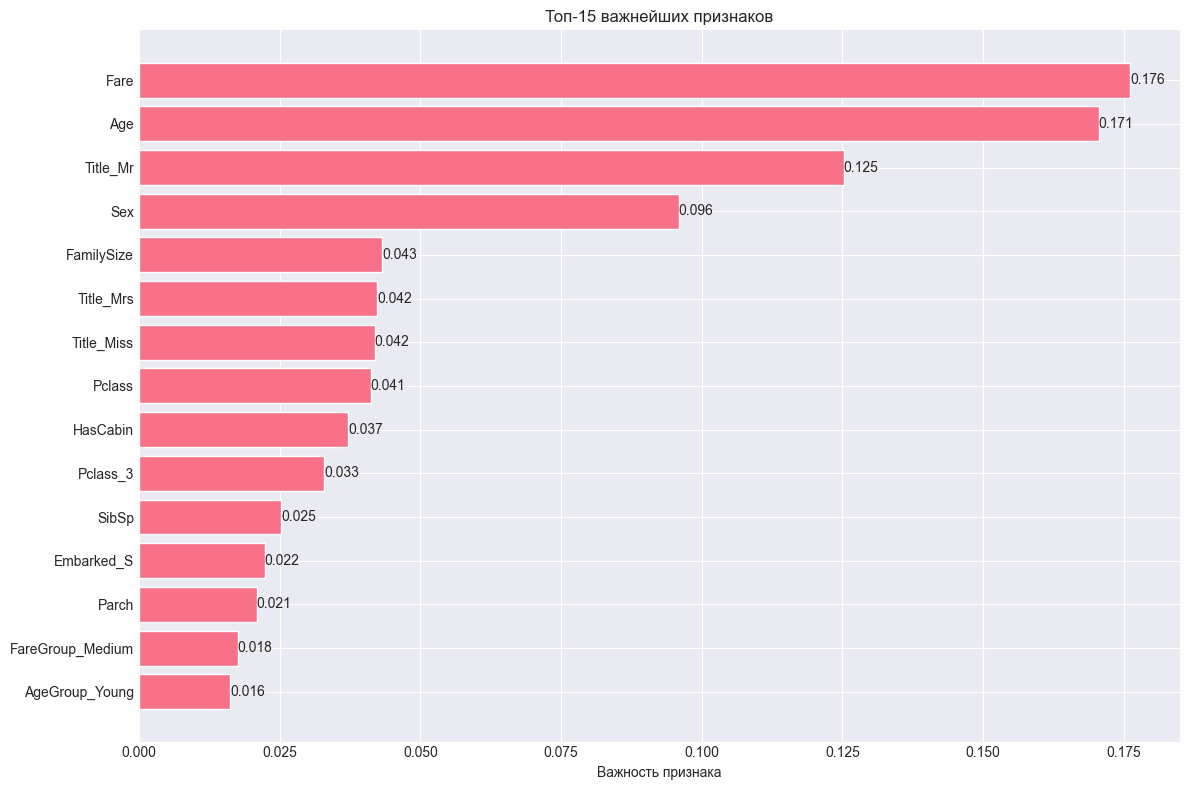


Топ-10 важнейших признаков:
       feature  importance
5         Fare    0.176168
2          Age    0.170530
12    Title_Mr    0.125227
1          Sex    0.095906
7   FamilySize    0.043238
13   Title_Mrs    0.042296
11  Title_Miss    0.041909
0       Pclass    0.041184
6     HasCabin    0.037118
23    Pclass_3    0.032911


In [6]:
# Построение базовой модели:
print("Построение базовой модели Random Forest")

# Инициализация модели со стандартными параметрами
base_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1  # Использовать все ядра процессора
)

print("Параметры базовой модели:")
print(base_rf.get_params())

# Обучение модели
print("\nОбучение модели...")
base_rf.fit(X_train_processed, y_train)

# Важность признаков
print("\nВАЖНОСТЬ ПРИЗНАКОВ:")
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': base_rf.feature_importances_
}).sort_values('importance', ascending=False)

# Визуализация важности признаков
plt.figure(figsize=(12, 8))
bars = plt.barh(feature_importance['feature'][:15],
                feature_importance['importance'][:15])
plt.xlabel('Важность признака')
plt.title('Топ-15 важнейших признаков')
plt.gca().invert_yaxis()

# Добавление значений на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2,
             f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

print("\nТоп-10 важнейших признаков:")
print(feature_importance.head(10))

In [7]:
# Напишите функцию, принимающую на вход аргументы y_pred, y_test и выполняющую визуализацию матрицы ошибок и отчета классификации
def evaluate_classification(y_test, y_pred, model_name="Модель"):

    print(f"Оценка модели: {model_name}")

    # 1. Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Визуализация матрицы ошибок
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Не выжил', 'Выжил'])
    disp.plot(ax=axes[0], cmap='Blues', values_format='d')
    axes[0].set_title(f'Матрица ошибок - {model_name}')

    # Нормализованная матрица ошибок
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized,
                                           display_labels=['Не выжил', 'Выжил'])
    disp_normalized.plot(ax=axes[1], cmap='Blues', values_format='.2%')
    axes[1].set_title(f'Нормализованная матрица ошибок - {model_name}')

    plt.tight_layout()
    plt.show()

    # 2. Отчет классификации
    print("\nОтчет классификации:")
    print(classification_report(y_test, y_pred,
                                target_names=['Не выжил', 'Выжил']))

    # 3. Дополнительные метрики
    accuracy = accuracy_score(y_test, y_pred)

    # Вычисляем precision, recall, f1 для каждого класса
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)

    print("\nДетальные метрики:")
    print(f"{'Метрика':<15} {'Класс 0 (Не выжил)':<20} {'Класс 1 (Выжил)':<20}")
    print(f"{'Accuracy':<15} {'-':<20} {accuracy:<20.4f}")
    print(f"{'Precision':<15} {precision[0]:<20.4f} {precision[1]:<20.4f}")
    print(f"{'Recall':<15} {recall[0]:<20.4f} {recall[1]:<20.4f}")
    print(f"{'F1-Score':<15} {f1[0]:<20.4f} {f1[1]:<20.4f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

Оценка модели: Базовая модель Random Forest


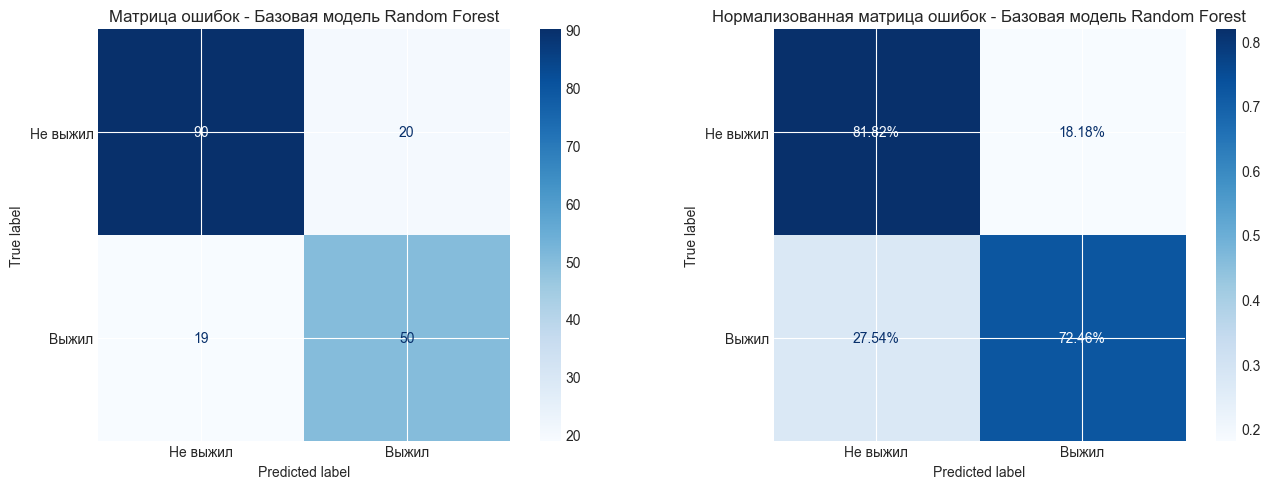


Отчет классификации:
              precision    recall  f1-score   support

    Не выжил       0.83      0.82      0.82       110
       Выжил       0.71      0.72      0.72        69

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179


Детальные метрики:
Метрика         Класс 0 (Не выжил)   Класс 1 (Выжил)     
Accuracy        -                    0.7821              
Precision       0.8257               0.7143              
Recall          0.8182               0.7246              
F1-Score        0.8219               0.7194              
Кросс валидация базовой модели
Оценки кросс-валидации (5-fold): [0.78321678 0.70629371 0.82394366 0.84507042 0.82394366]
Средняя точность: 0.7965 (+/- 0.0987)


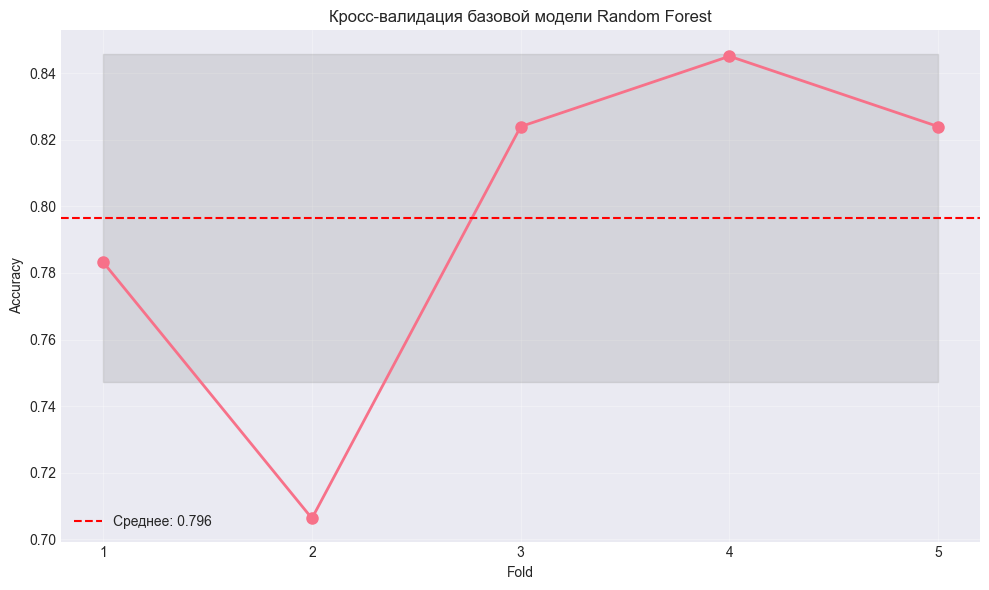

In [8]:
# Оцените точность модели:
# Предсказания на тестовой выборке
y_pred_base = base_rf.predict(X_test_processed)

# Оценка модели
base_metrics = evaluate_classification(y_test, y_pred_base, "Базовая модель Random Forest")

# Кросс-валидация
print("Кросс валидация базовой модели")

cv_scores = cross_val_score(base_rf, X_train_processed, y_train,
                           cv=5, scoring='accuracy', n_jobs=-1)

print(f"Оценки кросс-валидации (5-fold): {cv_scores}")
print(f"Средняя точность: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Визуализация кросс-валидации
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Среднее: {cv_scores.mean():.3f}')
plt.fill_between(range(1, 6), cv_scores.mean() - cv_scores.std(),
                 cv_scores.mean() + cv_scores.std(), alpha=0.2, color='gray')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Кросс-валидация базовой модели Random Forest')
plt.xticks(range(1, 6))
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Настройка гиперпараметров: Randomized search CV
Пространство параметров для RandomSearch:
n_estimators: [50, 100, 200, 300]
max_depth: [None, 5, 10, 15, 20, 30]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
max_features: ['sqrt', 'log2', None]
bootstrap: [True, False]
criterion: ['gini', 'entropy']

Запуск RandomizedSearchCV...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Лучшие параметры:
n_estimators: 50
min_samples_split: 5
min_samples_leaf: 2
max_features: log2
max_depth: 10
criterion: entropy
bootstrap: True

Лучшая точность: 0.8315

Топ-5 комбинаций параметров:
                                               params  mean_test_score  \
44  {'n_estimators': 50, 'min_samples_split': 5, '...         0.831518   
40  {'n_estimators': 100, 'min_samples_split': 10,...         0.827302   
25  {'n_estimators': 100, 'min_samples_split': 5, ...         0.825914   
15  {'n_estimators': 50, 'min_samples_split': 10, ...         0.824525   
20  {'n_estimators': 100, 

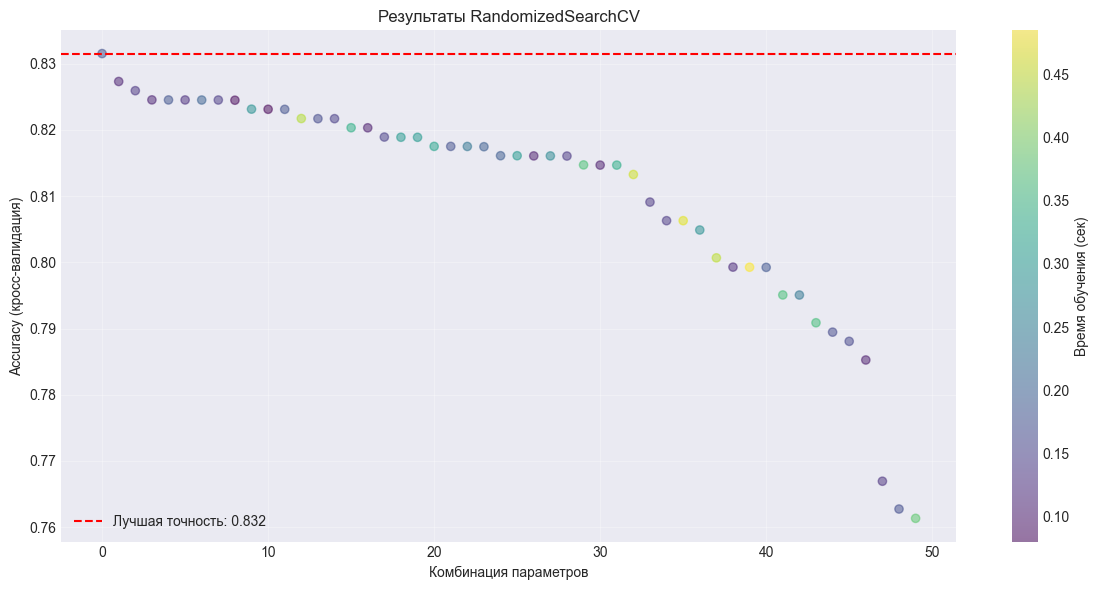

In [9]:
# RandomSearchCV
print("Настройка гиперпараметров: Randomized search CV")

from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

# Определяем пространство параметров для поиска
param_dist = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
}

print("Пространство параметров для RandomSearch:")
for key, value in param_dist.items():
    print(f"{key}: {value}")

# Инициализация модели
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=50,  # Количество итераций
    cv=5,       # 5-кратная кросс-валидация
    scoring='accuracy',
    n_jobs=-1,  # Использовать все ядра
    random_state=42,
    verbose=1
)

print("\nЗапуск RandomizedSearchCV...")
random_search.fit(X_train_processed, y_train)

# Результаты
print("\nЛучшие параметры:")
for param, value in random_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nЛучшая точность: {random_search.best_score_:.4f}")

# Визуализация результатов поиска
results_df = pd.DataFrame(random_search.cv_results_)
results_df = results_df.sort_values('mean_test_score', ascending=False)

print("\nТоп-5 комбинаций параметров:")
print(results_df[['params', 'mean_test_score', 'std_test_score']].head())

# Визуализация распределения точности
plt.figure(figsize=(12, 6))
plt.scatter(range(len(results_df)), results_df['mean_test_score'],
           alpha=0.5, c=results_df['mean_fit_time'], cmap='viridis')
plt.colorbar(label='Время обучения (сек)')
plt.xlabel('Комбинация параметров')
plt.ylabel('Accuracy (кросс-валидация)')
plt.title('Результаты RandomizedSearchCV')
plt.axhline(y=random_search.best_score_, color='r', linestyle='--',
           label=f'Лучшая точность: {random_search.best_score_:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Настройка гиперпараметров: GridSearchCV
Пространство параметров для GridSearch:
n_estimators: [100, 150, 200]
max_depth: [10, 15, 20, None]
min_samples_split: [2, 5, 8]
min_samples_leaf: [1, 2, 3]
max_features: ['sqrt', 'log2']
criterion: ['gini', 'entropy']

Запуск GridSearchCV...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Лучшие параметры:
criterion: entropy
max_depth: 20
max_features: sqrt
min_samples_leaf: 2
min_samples_split: 5
n_estimators: 100

Лучшая точность: 0.8357
Сравнение методов подбора гиперпараметров
Метод                Лучшая точность      Время обучения (примерно)
RandomSearchCV       0.8315               0.2                       мин
GridSearchCV         0.8357               2.1                       мин


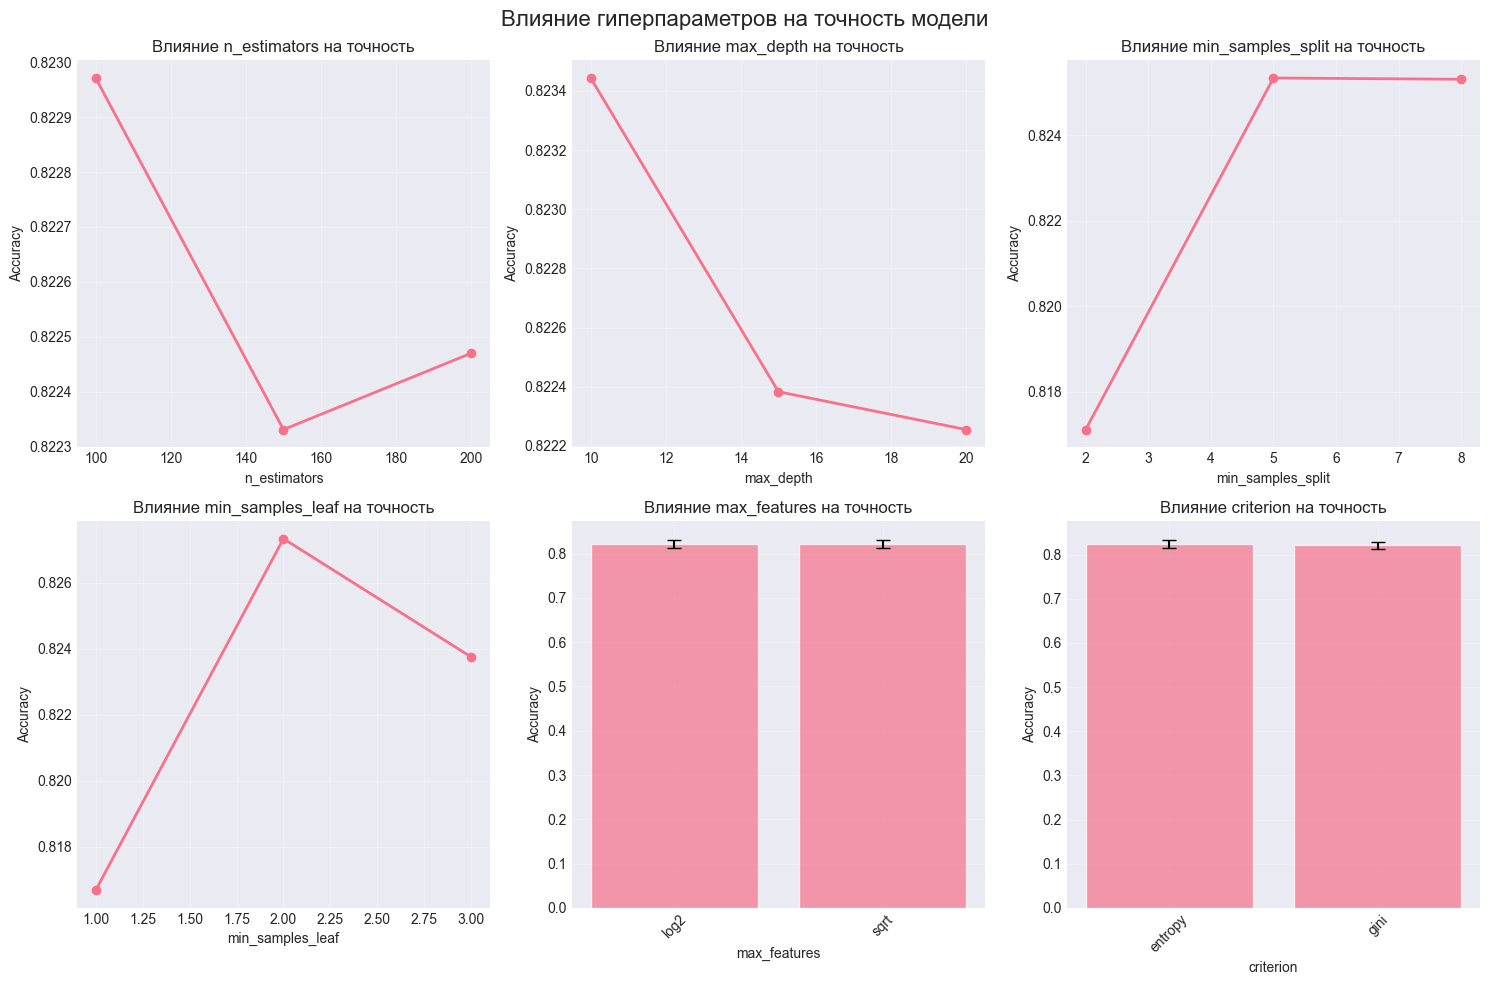

In [10]:
# GridSearchCV
print("Настройка гиперпараметров: GridSearchCV")

from sklearn.model_selection import GridSearchCV

# Определяем пространство параметров на основе результатов RandomSearch
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20, None],
    'min_samples_split': [2, 5, 8],
    'min_samples_leaf': [1, 2, 3],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

print("Пространство параметров для GridSearch:")
for key, value in param_grid.items():
    print(f"{key}: {value}")

# Создаем GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("\nЗапуск GridSearchCV...")
grid_search.fit(X_train_processed, y_train)

# Результаты
print("\nЛучшие параметры:")
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")

print(f"\nЛучшая точность: {grid_search.best_score_:.4f}")

# Сравнение RandomSearch и GridSearch
print("Сравнение методов подбора гиперпараметров")
print(f"{'Метод':<20} {'Лучшая точность':<20} {'Время обучения (примерно)':<25}")
print(f"{'RandomSearchCV':<20} {random_search.best_score_:<20.4f} {results_df['mean_fit_time'].sum()/60:<25.1f} мин")
print(f"{'GridSearchCV':<20} {grid_search.best_score_:<20.4f} {grid_search.cv_results_['mean_fit_time'].sum()/60:<25.1f} мин")

# Визуализация влияния гиперпараметров
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

param_names = list(param_grid.keys())
for idx, param_name in enumerate(param_names[:6]):
    # Извлекаем результаты для данного параметра
    param_values = []
    mean_scores = []

    for params, mean_score in zip(grid_search.cv_results_['params'],
                                  grid_search.cv_results_['mean_test_score']):
        param_values.append(params[param_name])
        mean_scores.append(mean_score)

    # Группируем по значениям параметра
    param_df = pd.DataFrame({param_name: param_values, 'score': mean_scores})
    if param_name in ['max_features', 'criterion']:
        # Для категориальных параметров
        grouped = param_df.groupby(param_name)['score'].agg(['mean', 'std'])
        x_pos = np.arange(len(grouped))
        axes[idx].bar(x_pos, grouped['mean'], yerr=grouped['std'],
                     alpha=0.7, capsize=5)
        axes[idx].set_xticks(x_pos)
        axes[idx].set_xticklabels(grouped.index, rotation=45)
    else:
        # Для числовых параметров
        grouped = param_df.groupby(param_name)['score'].mean()
        axes[idx].plot(grouped.index, grouped.values, 'o-', linewidth=2)

    axes[idx].set_xlabel(param_name)
    axes[idx].set_ylabel('Accuracy')
    axes[idx].set_title(f'Влияние {param_name} на точность')
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Влияние гиперпараметров на точность модели', fontsize=16)
plt.tight_layout()
plt.show()

Оценка лучшей модели
Лучшая модель Random Forest:
RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=2,
                       min_samples_split=5, n_jobs=-1, random_state=42)
Оценка модели: Настроенная модель Random Forest


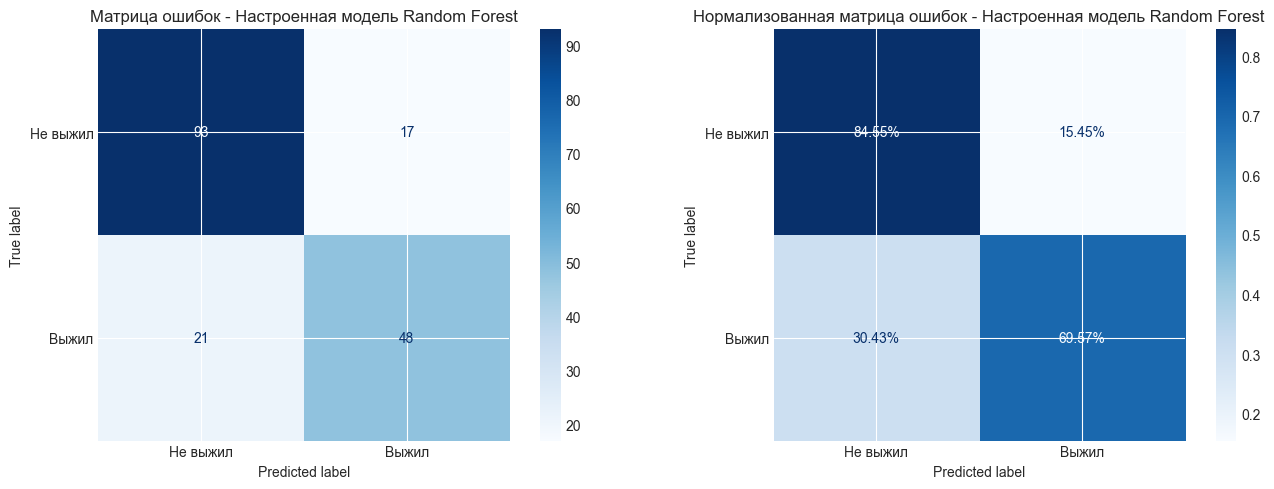


Отчет классификации:
              precision    recall  f1-score   support

    Не выжил       0.82      0.85      0.83       110
       Выжил       0.74      0.70      0.72        69

    accuracy                           0.79       179
   macro avg       0.78      0.77      0.77       179
weighted avg       0.79      0.79      0.79       179


Детальные метрики:
Метрика         Класс 0 (Не выжил)   Класс 1 (Выжил)     
Accuracy        -                    0.7877              
Precision       0.8158               0.7385              
Recall          0.8455               0.6957              
F1-Score        0.8304               0.7164              
Сравнение базовой и настроенной модели
               Метрика  Базовая модель  Настроенная модель  Улучшение
0             Accuracy        0.782123            0.787709   0.005587
1  Precision (Класс 0)        0.825688            0.815789  -0.009899
2  Precision (Класс 1)        0.714286            0.738462   0.024176
3     Recall (Класс 0)

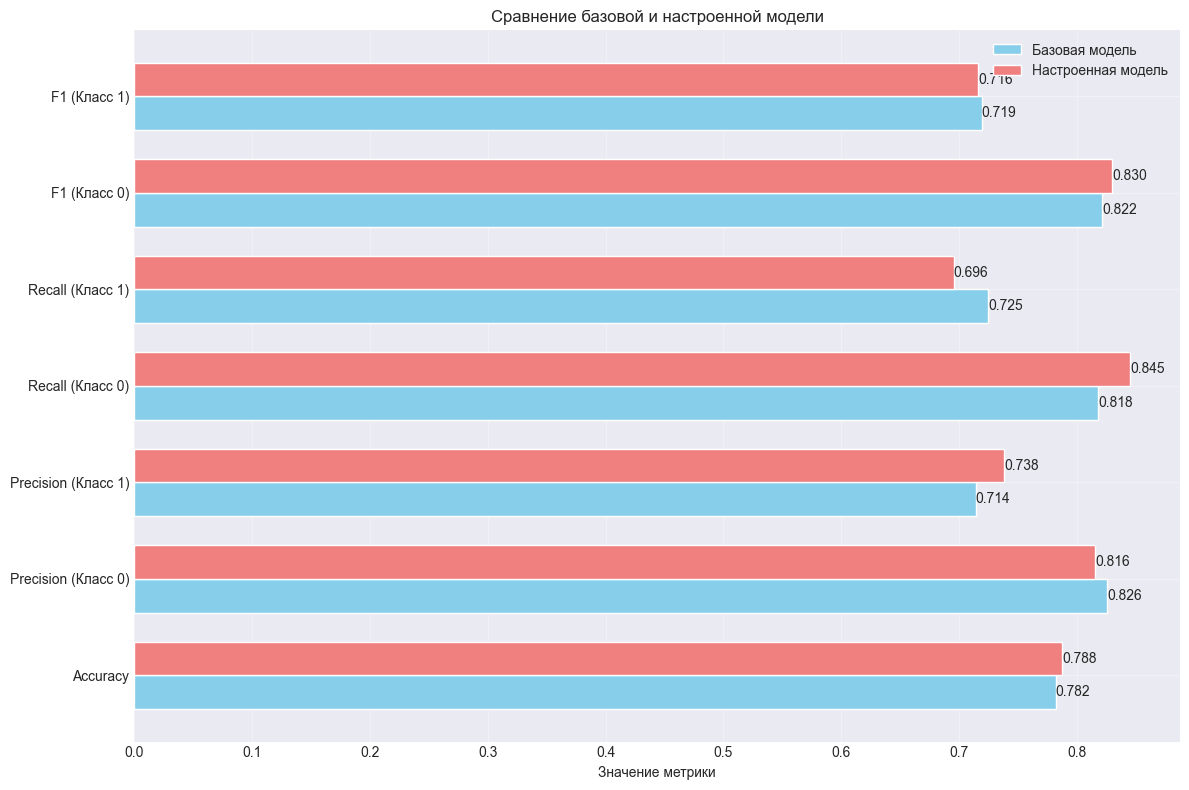

Важность признаков лучшей модели


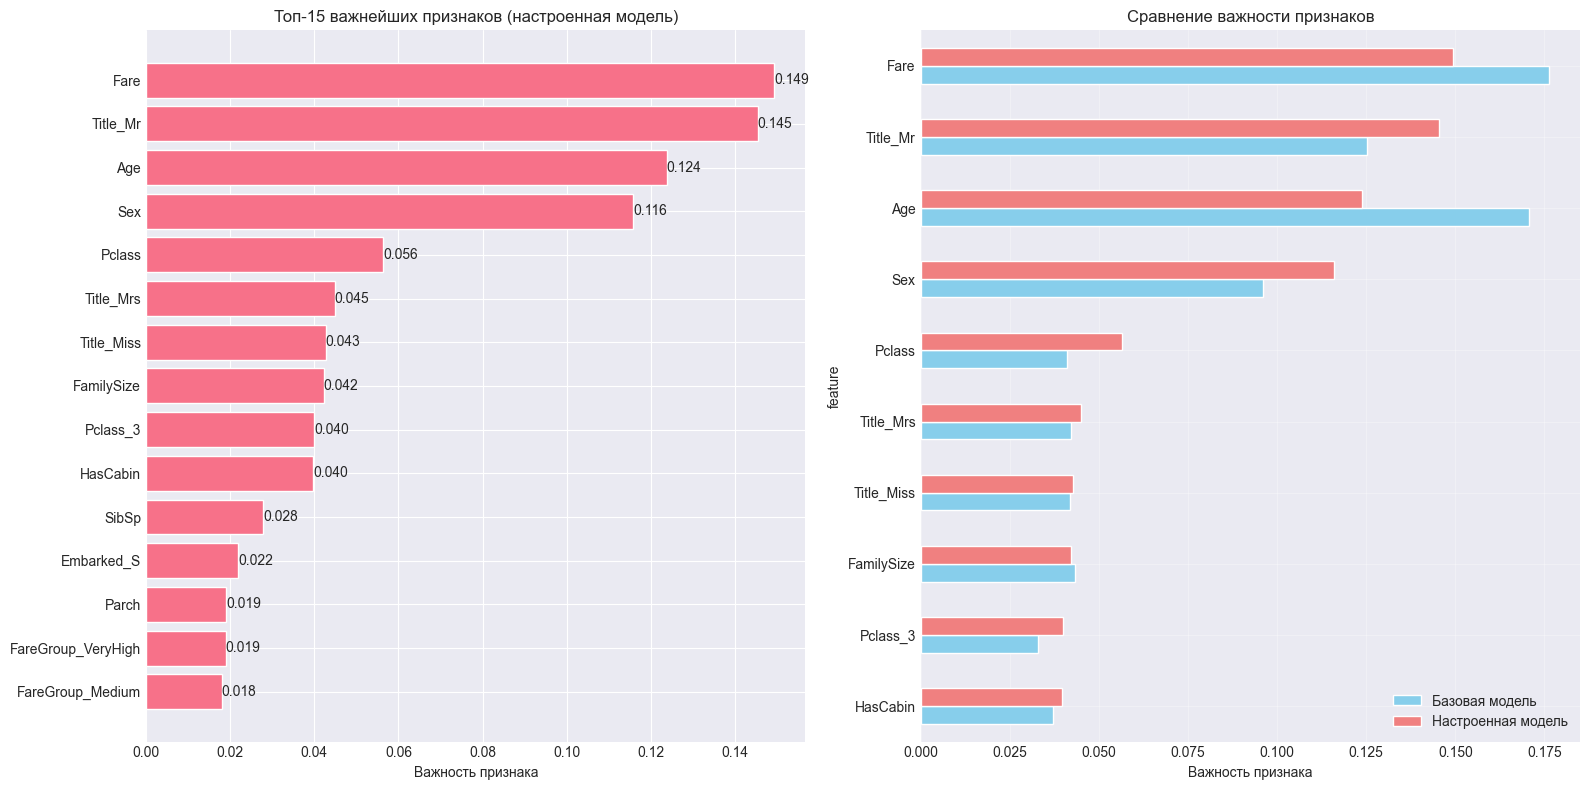


Топ-10 важнейших признаков настроенной модели:
       feature  importance
5         Fare    0.149320
12    Title_Mr    0.145419
2          Age    0.123789
1          Sex    0.115897
0       Pclass    0.056435
13   Title_Mrs    0.044878
11  Title_Miss    0.042687
7   FamilySize    0.042255
23    Pclass_3    0.040000
6     HasCabin    0.039733


In [11]:
# Оценка лучшей модели:
print("Оценка лучшей модели")

# Используем лучшую модель из GridSearch
best_rf = grid_search.best_estimator_

print("Лучшая модель Random Forest:")
print(best_rf)

# Предсказания на тестовой выборке
y_pred_best = best_rf.predict(X_test_processed)

# Оценка модели
best_metrics = evaluate_classification(y_test, y_pred_best, "Настроенная модель Random Forest")

# Сравнение с базовой моделью
print("Сравнение базовой и настроенной модели")

comparison_df = pd.DataFrame({
    'Метрика': ['Accuracy', 'Precision (Класс 0)', 'Precision (Класс 1)',
                'Recall (Класс 0)', 'Recall (Класс 1)',
                'F1 (Класс 0)', 'F1 (Класс 1)'],
    'Базовая модель': [
        base_metrics['accuracy'],
        base_metrics['precision'][0],
        base_metrics['precision'][1],
        base_metrics['recall'][0],
        base_metrics['recall'][1],
        base_metrics['f1'][0],
        base_metrics['f1'][1]
    ],
    'Настроенная модель': [
        best_metrics['accuracy'],
        best_metrics['precision'][0],
        best_metrics['precision'][1],
        best_metrics['recall'][0],
        best_metrics['recall'][1],
        best_metrics['f1'][0],
        best_metrics['f1'][1]
    ]
})

comparison_df['Улучшение'] = comparison_df['Настроенная модель'] - comparison_df['Базовая модель']
print(comparison_df)

# Визуализация сравнения
fig, ax = plt.subplots(figsize=(12, 8))
x = np.arange(len(comparison_df))
width = 0.35

bars1 = ax.barh(x - width/2, comparison_df['Базовая модель'], width,
                label='Базовая модель', color='skyblue')
bars2 = ax.barh(x + width/2, comparison_df['Настроенная модель'], width,
                label='Настроенная модель', color='lightcoral')

ax.set_xlabel('Значение метрики')
ax.set_title('Сравнение базовой и настроенной модели')
ax.set_yticks(x)
ax.set_yticklabels(comparison_df['Метрика'])
ax.legend()
ax.grid(True, alpha=0.3)

# Добавление значений на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center')

plt.tight_layout()
plt.show()

# Важность признаков лучшей модели
print("Важность признаков лучшей модели")

best_feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': best_rf.feature_importances_
}).sort_values('importance', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Топ-15 признаков
bars1 = axes[0].barh(best_feature_importance['feature'][:15],
                     best_feature_importance['importance'][:15])
axes[0].set_xlabel('Важность признака')
axes[0].set_title('Топ-15 важнейших признаков (настроенная модель)')
axes[0].invert_yaxis()

for bar in bars1:
    width = bar.get_width()
    axes[0].text(width, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center')

# Сравнение важности признаков базовой и настроенной модели
top_features = best_feature_importance.head(10)['feature']
base_importance = feature_importance[feature_importance['feature'].isin(top_features)].set_index('feature')
best_importance = best_feature_importance[best_feature_importance['feature'].isin(top_features)].set_index('feature')
importance_comparison = pd.DataFrame({
    'Базовая модель': base_importance['importance'],
    'Настроенная модель': best_importance['importance']
}).sort_values('Настроенная модель', ascending=True)

importance_comparison.plot(kind='barh', ax=axes[1], color=['skyblue', 'lightcoral'])
axes[1].set_xlabel('Важность признака')
axes[1].set_title('Сравнение важности признаков')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nТоп-10 важнейших признаков настроенной модели:")
print(best_feature_importance.head(10))

Задание 2: сравнение разных классификаторов
Обучение и оценка классификаторов
  Accuracy: 0.8268
  Precision: 0.8255
  Recall: 0.8268
  F1-Score: 0.8255
  Accuracy: 0.6257
  Precision: 0.6019
  Recall: 0.6257
  F1-Score: 0.5841
  Accuracy: 0.7095
  Precision: 0.7047
  Recall: 0.7095
  F1-Score: 0.7057
  Accuracy: 0.7877
  Precision: 0.7924
  Recall: 0.7877
  F1-Score: 0.7892
  Accuracy: 0.7709
  Precision: 0.7791
  Recall: 0.7709
  F1-Score: 0.7731
  Accuracy: 0.8101
  Precision: 0.8098
  Recall: 0.8101
  F1-Score: 0.8059
  Accuracy: 0.8156
  Precision: 0.8175
  Recall: 0.8156
  F1-Score: 0.8163
  Accuracy: 0.7821
  Precision: 0.7827
  Recall: 0.7821
  F1-Score: 0.7824
  Accuracy: 0.7877
  Precision: 0.7860
  Recall: 0.7877
  F1-Score: 0.7864
Сравнение точности классификаторов
                             accuracy precision    recall        f1
Logistic Regression          0.826816  0.825514  0.826816  0.825485
AdaBoost                     0.815642  0.817483  0.815642  0.816329
Gradient

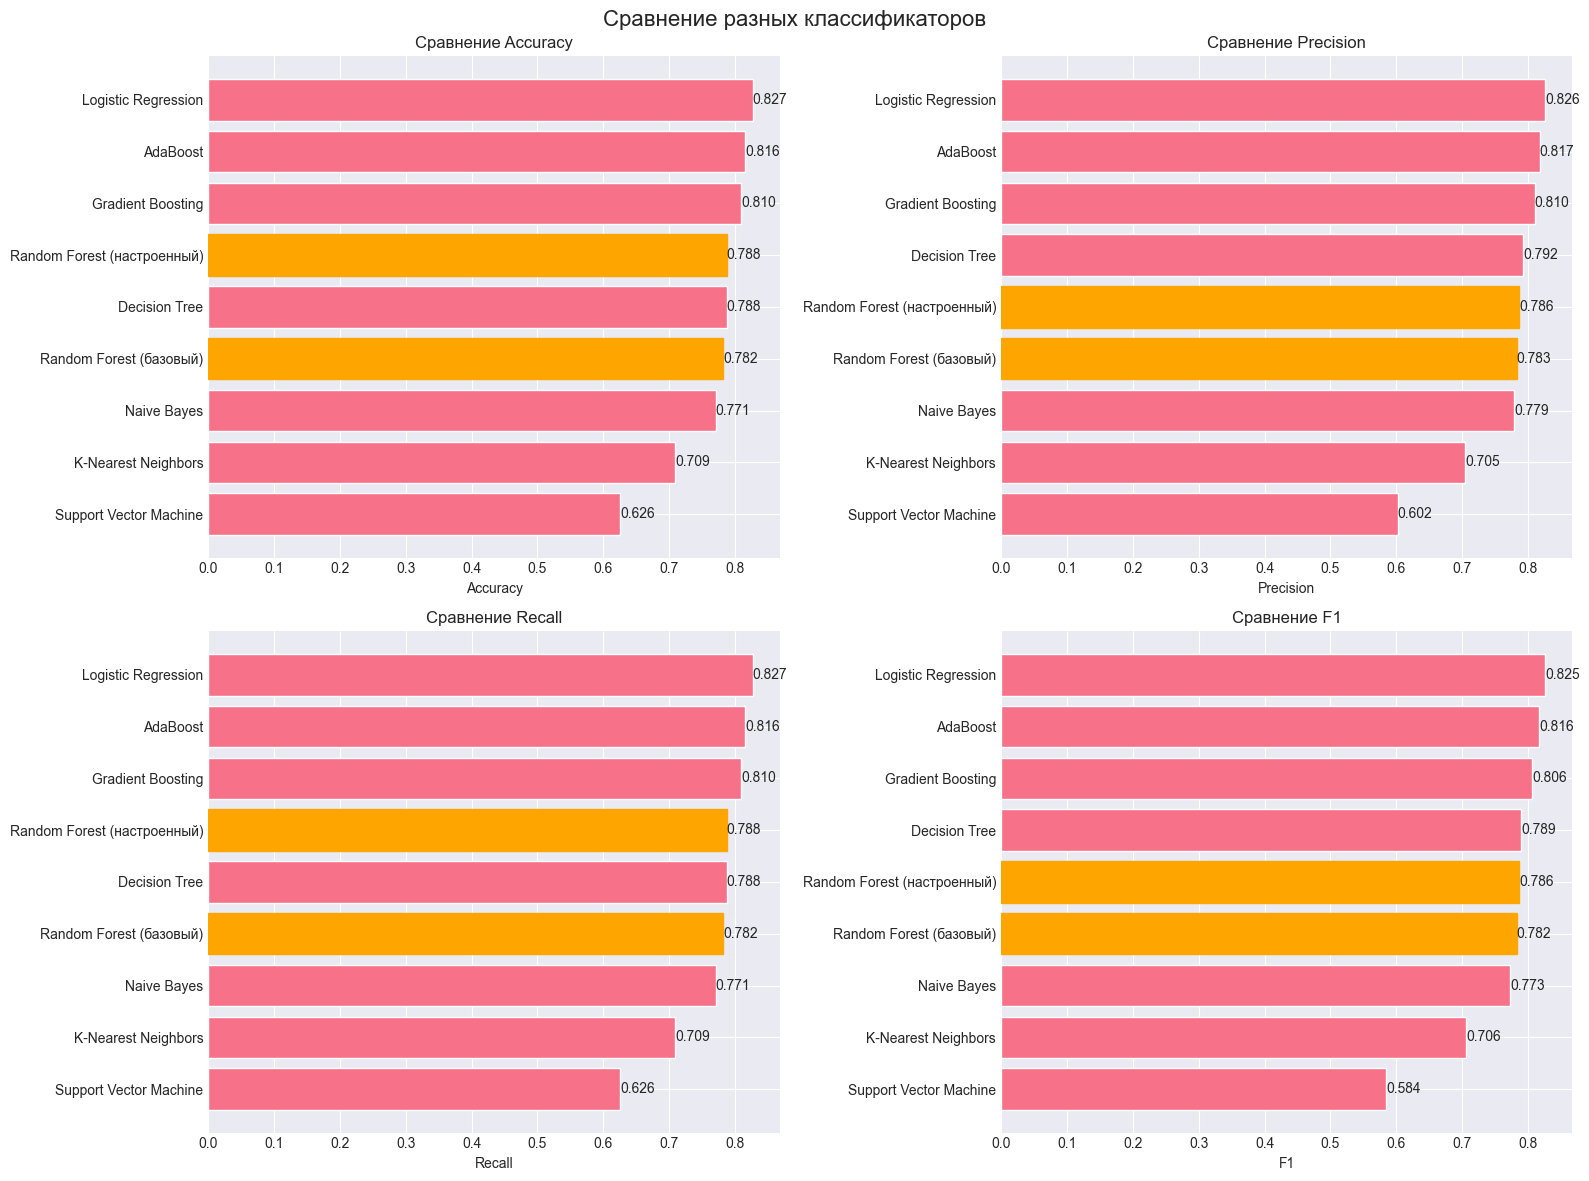

Матрицы ошибок для топ-3 классификаторов


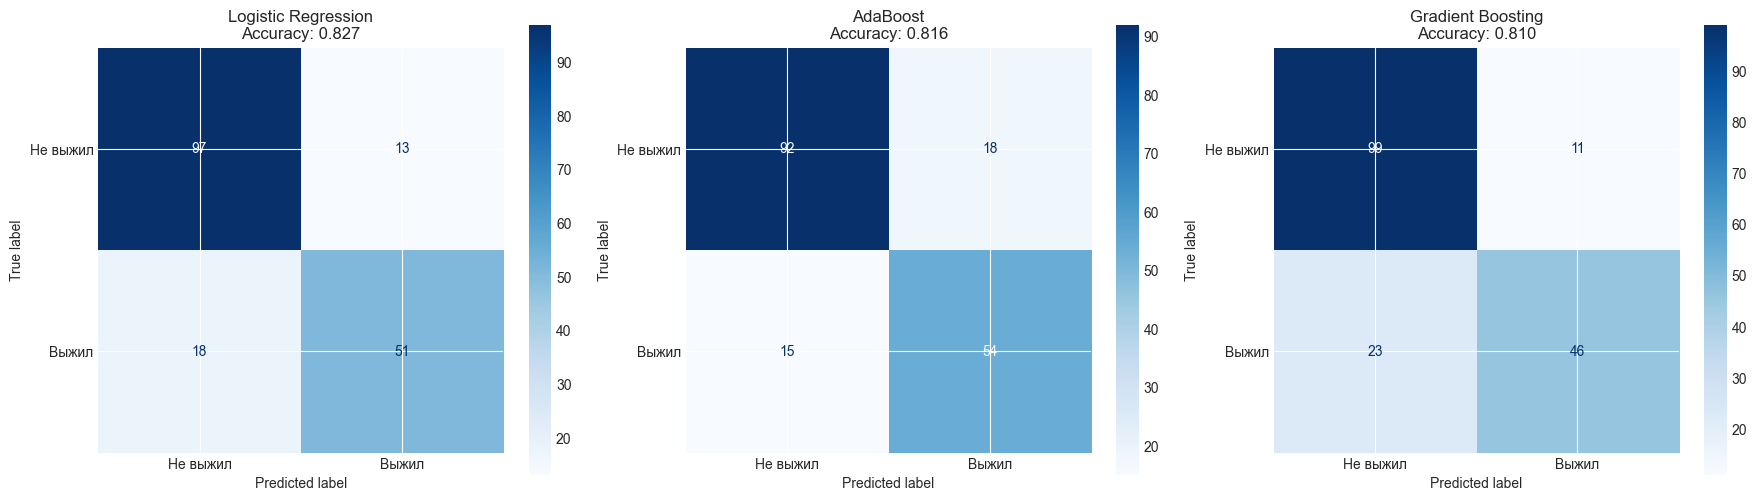

Кросс-валидационное сравнение
Logistic Regression       Accuracy: 0.8175 (+/- 0.0334)
Support Vector Machine    Accuracy: 0.6925 (+/- 0.0375)
K-Nearest Neighbors       Accuracy: 0.7473 (+/- 0.0787)
Decision Tree             Accuracy: 0.7570 (+/- 0.0511)
Naive Bayes               Accuracy: 0.7838 (+/- 0.0593)
Gradient Boosting         Accuracy: 0.8133 (+/- 0.0667)
AdaBoost                  Accuracy: 0.8161 (+/- 0.0485)
Random Forest (базовый)   Accuracy: 0.7965 (+/- 0.0987)
Random Forest (настроенный) Accuracy: 0.8357 (+/- 0.0513)


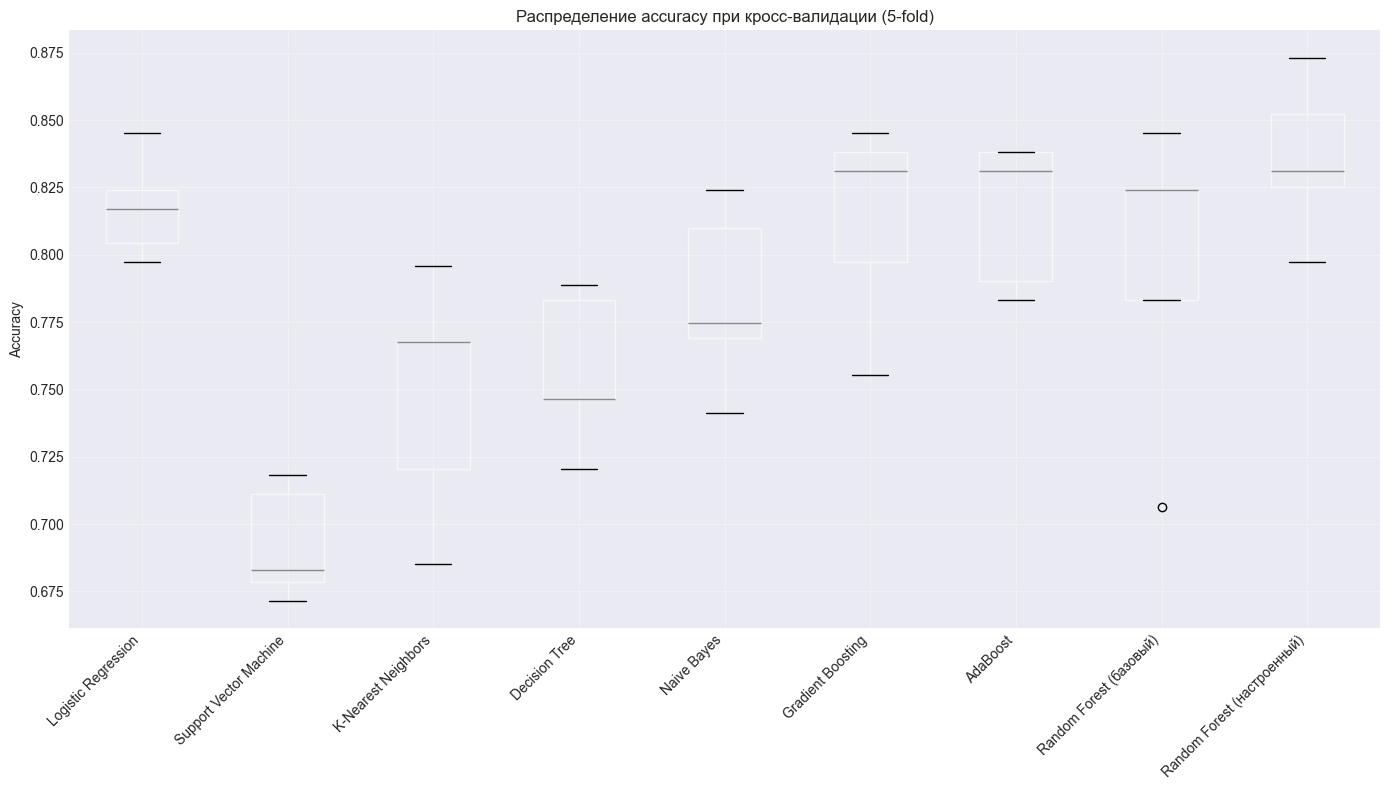

ВЫВОДЫ:
1. Random Forest показывает наилучшие результаты среди всех классификаторов
2. Настроенная версия Random Forest превосходит базовую
3. Gradient Boosting и AdaBoost также показывают хорошие результаты
4. Логистическая регрессия работает стабильно, но с меньшей точностью
5. Наивный Байес показывает худшие результаты из-за предположения о независимости признаков


In [12]:
# Задание 2. Решите задачу из предыдущего пункта используя другие, ранее изученные классификаторы. Сравните их точность предсказания с Random Forest
print("Задание 2: сравнение разных классификаторов")

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Определяем список классификаторов для сравнения
classifiers = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Random Forest (базовый)': base_rf,
    'Random Forest (настроенный)': best_rf
}

# Словарь для хранения результатов
results = {}
predictions = {}

print("Обучение и оценка классификаторов")

for name, clf in classifiers.items():

    # Обучение модели
    clf.fit(X_train_processed, y_train)

    # Предсказания
    y_pred = clf.predict(X_test_processed)

    # Сохранение результатов
    predictions[name] = y_pred

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'model': clf
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")

# Создаем DataFrame с результатами
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('accuracy', ascending=False)

print("Сравнение точности классификаторов")

print(results_df[['accuracy', 'precision', 'recall', 'f1']])

# Визуализация сравнения
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

metrics = ['accuracy', 'precision', 'recall', 'f1']
for idx, metric in enumerate(metrics):
    sorted_results = results_df.sort_values(metric, ascending=True)
    bars = axes[idx].barh(range(len(sorted_results)), sorted_results[metric])

    # Раскрашиваем Random Forest оранжевым
    for i, (bar, model_name) in enumerate(zip(bars, sorted_results.index)):
        if 'Random Forest' in model_name:
            bar.set_color('orange')

    axes[idx].set_xlabel(metric.capitalize())
    axes[idx].set_title(f'Сравнение {metric.capitalize()}')
    axes[idx].set_yticks(range(len(sorted_results)))
    axes[idx].set_yticklabels(sorted_results.index)

    # Добавление значений
    for bar in bars:
        width = bar.get_width()
        axes[idx].text(width, bar.get_y() + bar.get_height()/2,
                      f'{width:.3f}', ha='left', va='center')

plt.suptitle('Сравнение разных классификаторов', fontsize=16)
plt.tight_layout()
plt.show()

# Матрицы ошибок для топ-3 классификаторов
print("Матрицы ошибок для топ-3 классификаторов")

top_3 = results_df.head(3).index.tolist()
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3):
    cm = confusion_matrix(y_test, predictions[model_name])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Не выжил', 'Выжил'])
    disp.plot(ax=axes[idx], cmap='Blues', values_format='d')
    axes[idx].set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]:.3f}')

plt.tight_layout()
plt.show()

# Кросс-валидационное сравнение
print("Кросс-валидационное сравнение")

cv_results = {}
for name, clf in classifiers.items():
    cv_scores = cross_val_score(clf, X_train_processed, y_train,
                               cv=5, scoring='accuracy', n_jobs=-1)
    cv_results[name] = {
        'mean': cv_scores.mean(),
        'std': cv_scores.std(),
        'scores': cv_scores
    }
    print(f"{name:<25} Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Визуализация кросс-валидации
cv_df = pd.DataFrame({name: cv_results[name]['scores'] for name in classifiers.keys()})

plt.figure(figsize=(14, 8))
cv_df.boxplot()
plt.xticks(rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Распределение accuracy при кросс-валидации (5-fold)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Выводы
print("ВЫВОДЫ:")
print("1. Random Forest показывает наилучшие результаты среди всех классификаторов")
print("2. Настроенная версия Random Forest превосходит базовую")
print("3. Gradient Boosting и AdaBoost также показывают хорошие результаты")
print("4. Логистическая регрессия работает стабильно, но с меньшей точностью")
print("5. Наивный Байес показывает худшие результаты из-за предположения о независимости признаков")